In [11]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import spacy 
import optuna
import umap
import xgboost as xgb
import re

import sys; sys.path.insert(0, '../') #adds all the code we've written in src
from tqdm.notebook import trange, tqdm
from preprocessing import *

from sklearnex import patch_sklearn
patch_sklearn()

from sklearnex.svm import SVC
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score as f1
from sklearn.linear_model import LogisticRegression as LR
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer as tfidf
from sklearn.preprocessing import MaxAbsScaler

import warnings #this my friends is overconfidence at it's finest
warnings.filterwarnings("ignore")

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Encoding Data and Creating Train, Validation, Testing Splits

In [4]:
df = pd.read_csv("../../cyberbullying_tweets/processed_tweets.csv", index_col = 0)
X = df.ascii.to_numpy()
y = df.y.to_numpy()

print(f"Shape of raw data\n\nX: {X.shape}\nY: {y.shape}\n")

###create train, test, and validation splits of the data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42122, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.176, random_state=42122, stratify=y_train)

print(f"Shape of split data\n\nTrain: {X_train.shape}\nValidation: {X_val.shape}\nTest: {X_test.shape}\n")

###fit bag-of-words embeddings on training data and then use to transform all splits 
bow_vectorizer = CountVectorizer(tokenizer=word_tokenize, analyzer = 'word', stop_words=None, ngram_range=(1,1), lowercase=False)
bow_vectorizer.fit(X_train)

X_train_bow, X_val_bow, X_test_bow = (bow_vectorizer.transform(dataset) for dataset in [X_train, X_val, X_test])

print(f"Shape of BOW \n\nTrain: {X_train_bow.shape}\nValidation: {X_val_bow.shape}\nTest: {X_test_bow.shape}\n")

###fit tf-idf embeddings on training data and then use to transform all splits
tf_vectorizer = tfidf()
tf_vectorizer.fit(X_train_bow)

X_train_tfidf, X_val_tfidf, X_test_tfidf = (tf_vectorizer.transform(dataset) for dataset in [X_train_bow, X_val_bow, X_test_bow])

print(f"Shape of tf-idf \n\nTrain: {X_train_bow.shape}\nValidation: {X_val_bow.shape}\nTest: {X_test_bow.shape}")

Shape of raw data

X: (41176,)
Y: (41176,)

Shape of split data

Train: (28839,)
Validation: (6160,)
Test: (6177,)

Shape of BOW 

Train: (28839, 38255)
Validation: (6160, 38255)
Test: (6177, 38255)

Shape of tf-idf 

Train: (28839, 38255)
Validation: (6160, 38255)
Test: (6177, 38255)


# Logistic Regression 

The multinomial logistic regression didn't require any complicated hyperparamter tuning. The multinomial setting did well in testing, and excessive normalization didn't make too much of a difference.

In [4]:
log_reg_bow = LR(max_iter=10000, solver = 'saga', multi_class='multinomial').fit(X_train_bow, y_train)
y_pred_lr_bow = log_reg_bow.predict(X_test_bow)

print("BOW Embedding Classification Report")
print(f"Model Accuracy: {accuracy(y_test, y_pred_lr_bow)}")
print(classification_report(y_test, y_pred_lr_bow), "\n")

log_reg_tfidf = LR(max_iter=10000, solver = 'saga', multi_class='multinomial').fit(X_train_tfidf, y_train)
y_pred_lr_tfidf = log_reg_tfidf.predict(X_test_tfidf)

print("TFIDF Embedding Classification Report")
print(f"Model Accuracy: {accuracy(y_test, y_pred_lr_tfidf)}")
print(classification_report(y_test, y_pred_lr_tfidf), "\n")

BOW Embedding Classification Report
Model Accuracy: 0.8526792941557391
              precision    recall  f1-score   support

           0       0.59      0.63      0.61       899
           1       0.90      0.87      0.88      1083
           2       0.95      0.94      0.94      1183
           3       0.60      0.61      0.60       744
           4       0.97      0.97      0.97      1177
           5       0.99      0.97      0.98      1091

    accuracy                           0.85      6177
   macro avg       0.83      0.83      0.83      6177
weighted avg       0.86      0.85      0.85      6177
 

TFIDF Embedding Classification Report
Model Accuracy: 0.8473368949328153
              precision    recall  f1-score   support

           0       0.58      0.61      0.59       899
           1       0.90      0.85      0.88      1083
           2       0.93      0.95      0.94      1183
           3       0.62      0.59      0.60       744
           4       0.95      0.97      0

# SVMs and Optuna 

Here we create the support vector machine and train it's hyperparamters using Optuna. Optuna relies on bayesian hyperparamter sampling rather than a reductive grid search. This saves computation time while ensuring good results. The trial defines the search space for hyperparamters. This process must be repeated for both BOW and TF-IDF embeddings. The trial will attempt to maximize the validation accuracy. 

In [5]:
class svm_optimizer():

    def __init__(self, X_train, X_val, X_test, y_train, y_val, y_test, study_name): 
        """
        Initialize Objectives with data. Allows for code reuse. 
        """
        self.models = [] #save all models tested
        self.X_train, self.X_val, self.X_test = X_train, X_val, X_test
        self.y_train, self.y_val, self.y_test = y_train, y_val, y_test
        self.study = optuna.create_study(study_name = study_name, direction = "maximize")
    
    def objective(self, trial): 
        kernels = ["linear", "rbf", "sigmoid"]
        kernel = trial.suggest_categorical("kernel", kernels)
        regularization = trial.suggest_float("regularization", 0, 1)
        gamma = trial.suggest_loguniform("gamma", 10e-3, 10e3)

        model = SVC(max_iter = 10000, C = regularization, gamma = gamma,
                    kernel = kernel).fit(self.X_train, self.y_train)
        self.models.append(model) 

        y_pred = model.predict(self.X_val)
        return accuracy(self.y_val, y_pred)
    
    def optimize(self, n_trials = 20):
        """
        Optimizes the objective with the given study. Can be called multiple times 
        and will save the state. 
        """
        self.study.optimize(self.objective, n_trials = n_trials)
        
    def get_best_model(self):
        """
        Returns None if no optimization has occured. Else returns the best model 
        so far according to the study. 
        """
        if self.models is None: 
            return None
        
        return self.models[self.study.best_trial.number]

In [7]:
#BOW Optimization
svm_bow_optimizer = svm_optimizer(X_train_bow, X_val_bow, X_test_bow, y_train, y_val, y_test, "SVM BOW Optimzer")
svm_bow_optimizer.optimize(20)
svm_bow = svm_bow_optimizer.get_best_model()

[I 2022-04-21 23:04:46,009] A new study created in memory with name: SVM BOW Optimzer
[I 2022-04-21 23:05:05,178] Trial 0 finished with value: 0.7913961038961039 and parameters: {'kernel': 'linear', 'regularization': 0.0016986325574974703, 'gamma': 0.9686189355821254}. Best is trial 0 with value: 0.7913961038961039.
[I 2022-04-21 23:05:30,295] Trial 1 finished with value: 0.2297077922077922 and parameters: {'kernel': 'sigmoid', 'regularization': 0.6768845597479997, 'gamma': 12.703604099600875}. Best is trial 0 with value: 0.7913961038961039.
[I 2022-04-21 23:05:55,472] Trial 2 finished with value: 0.2297077922077922 and parameters: {'kernel': 'sigmoid', 'regularization': 0.5304538899902461, 'gamma': 77.50452557518204}. Best is trial 0 with value: 0.7913961038961039.
[I 2022-04-21 23:06:10,737] Trial 3 finished with value: 0.8425324675324676 and parameters: {'kernel': 'linear', 'regularization': 0.011974143645818724, 'gamma': 4.570742277697089}. Best is trial 3 with value: 0.84253246753

In [8]:
#tf_idf optimization
svm_tfidf_optimizer = svm_optimizer(X_train_tfidf, X_val_tfidf, X_test_tfidf, y_train, y_val, y_test, "SVM TF-IDF Optimizer")
svm_tfidf_optimizer.optimize(20)
svm_tfidf = svm_tfidf_optimizer.get_best_model()

[I 2022-04-21 23:12:37,980] A new study created in memory with name: SVM TF-IDF Optimizer
[I 2022-04-21 23:13:03,832] Trial 0 finished with value: 0.8154220779220779 and parameters: {'kernel': 'rbf', 'regularization': 0.757344767451486, 'gamma': 0.04778698667791589}. Best is trial 0 with value: 0.8154220779220779.
[I 2022-04-21 23:13:41,155] Trial 1 finished with value: 0.639448051948052 and parameters: {'kernel': 'rbf', 'regularization': 0.44213525039900203, 'gamma': 165.70985546763447}. Best is trial 0 with value: 0.8154220779220779.
[I 2022-04-21 23:14:15,929] Trial 2 finished with value: 0.23863636363636365 and parameters: {'kernel': 'rbf', 'regularization': 0.7241849418837045, 'gamma': 670.9616502109103}. Best is trial 0 with value: 0.8154220779220779.
[I 2022-04-21 23:14:37,290] Trial 3 finished with value: 0.8561688311688311 and parameters: {'kernel': 'linear', 'regularization': 0.6897147072790143, 'gamma': 0.014126985518458939}. Best is trial 3 with value: 0.8561688311688311.
[

In [9]:
y_pred_svm_bow = svm_bow.predict(X_test_bow)
y_pred_svm_tfidf = svm_tfidf.predict(X_test_tfidf)

print("BOW Embedding Classification Report")
print(f"Model Accuracy: {accuracy(y_test, y_pred_svm_bow)}")
print(classification_report(y_test, y_pred_svm_bow), "\n")


print("TFIDF Embedding Classification Report")
print(f"Model Accuracy: {accuracy(y_test, y_pred_svm_tfidf)}")
print(classification_report(y_test, y_pred_svm_tfidf), "\n")

BOW Embedding Classification Report
Model Accuracy: 0.8539744212400842
              precision    recall  f1-score   support

           0       0.57      0.67      0.62       899
           1       0.91      0.85      0.88      1083
           2       0.95      0.94      0.94      1183
           3       0.63      0.60      0.61       744
           4       0.98      0.96      0.97      1177
           5       0.99      0.97      0.98      1091

    accuracy                           0.85      6177
   macro avg       0.84      0.83      0.83      6177
weighted avg       0.86      0.85      0.86      6177
 

TFIDF Embedding Classification Report
Model Accuracy: 0.8575360207220334
              precision    recall  f1-score   support

           0       0.59      0.63      0.61       899
           1       0.91      0.87      0.89      1083
           2       0.95      0.95      0.95      1183
           3       0.63      0.62      0.62       744
           4       0.96      0.97      0

# Gradient Boosted Trees with XGBoost 

Gradient boosted trees are a favorite for classification tasks. The data has to be loaded in slightly strange manner, but we can still use optuna for tuning the hyperparameters.

In [5]:
D_train_bow = xgb.DMatrix(X_train_bow, label=y_train)
D_val_bow = xgb.DMatrix(X_val_bow, label = y_val)
D_test_bow = xgb.DMatrix(X_test_bow, label = y_test)

D_train_tfidf = xgb.DMatrix(X_train_tfidf, label=y_train)
D_val_tfidf = xgb.DMatrix(X_val_tfidf, label = y_val)
D_test_tfidf = xgb.DMatrix(X_test_tfidf, label = y_test)

In [15]:
class xgb_optimizer(svm_optimizer): 
    
    def __init__(self, train, val, test, study_name): 
        self.models = []
        self.train = train
        self.val = val 
        self.test = test
        self.study = optuna.create_study(study_name = study_name, direction = "maximize")

    
    def objective(self, trial): 
        param = {
            'eta': trial.suggest_loguniform("eta", 10e-4, 1), 
            'max_depth': trial.suggest_int("max_depth", 2, 6),  
            'booster': trial.suggest_categorical('booster', ["gbtree", "dart"]),
            'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
            'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
            'objective': 'multi:softprob',  
            'eval_metric': 'mlogloss',
            'num_class': 6} 

        steps = 50

        model = xgb.train(param, self.train, steps)
        self.models.append(model)
        
        y_pred_prob = model.predict(self.val)
        y_pred = np.argmax(y_pred_prob, axis = 1)

        return accuracy(y_val, y_pred)

In [18]:
xgb_bow_optimizer = xgb_optimizer(D_train_bow, D_val_bow, D_test_bow, "XGB BOW Optimzer")
xgb_bow_optimizer.optimize(20)
xgb_bow = xgb_bow_optimizer.get_best_model()

[I 2022-04-21 23:30:24,718] A new study created in memory with name: XGB BOW Optimzer
[I 2022-04-21 23:30:34,092] Trial 0 finished with value: 0.7688311688311689 and parameters: {'eta': 0.0011833063328328703, 'max_depth': 4, 'booster': 'gbtree', 'lambda': 1.6466892397349498e-08, 'alpha': 0.0871672293961406}. Best is trial 0 with value: 0.7688311688311689.
[I 2022-04-21 23:30:44,830] Trial 1 finished with value: 0.8566558441558442 and parameters: {'eta': 0.37815622982471697, 'max_depth': 5, 'booster': 'gbtree', 'lambda': 1.5322573904727991e-06, 'alpha': 0.00033642201582319536}. Best is trial 1 with value: 0.8566558441558442.
[I 2022-04-21 23:31:36,373] Trial 2 finished with value: 0.8323051948051948 and parameters: {'eta': 0.07114725886605043, 'max_depth': 6, 'booster': 'dart', 'lambda': 0.02138047734174046, 'alpha': 8.863435827800102e-08}. Best is trial 1 with value: 0.8566558441558442.
[I 2022-04-21 23:31:43,925] Trial 3 finished with value: 0.7571428571428571 and parameters: {'eta': 

In [19]:
xgb_tfidf_optimizer = xgb_optimizer(D_train_tfidf, D_val_tfidf, D_test_tfidf, "XGB TF-IDF Optimzer")
xgb_tfidf_optimizer.optimize(20)
xgb_tfidf = xgb_tfidf_optimizer.get_best_model()

[I 2022-04-21 23:36:16,131] A new study created in memory with name: XGB TF-IDF Optimzer
[I 2022-04-21 23:36:58,658] Trial 0 finished with value: 0.8422077922077922 and parameters: {'eta': 0.356575162645744, 'max_depth': 2, 'booster': 'dart', 'lambda': 0.017245465493907514, 'alpha': 4.022314211971918e-07}. Best is trial 0 with value: 0.8422077922077922.
[I 2022-04-21 23:37:42,671] Trial 1 finished with value: 0.8542207792207792 and parameters: {'eta': 0.3701837019177327, 'max_depth': 6, 'booster': 'gbtree', 'lambda': 0.0011355814000466925, 'alpha': 0.00020136925614271174}. Best is trial 1 with value: 0.8542207792207792.
[I 2022-04-21 23:38:23,333] Trial 2 finished with value: 0.7853896103896104 and parameters: {'eta': 0.0020483243989624224, 'max_depth': 5, 'booster': 'gbtree', 'lambda': 0.0007138407093633312, 'alpha': 0.019510477146694363}. Best is trial 1 with value: 0.8542207792207792.
[I 2022-04-21 23:38:55,661] Trial 3 finished with value: 0.7881493506493507 and parameters: {'eta':

In [6]:
#let models train fully 
bow_param = {'eta': 0.395725189484906, 
        'max_depth': 8,  
        'booster': "gbtree",
        'lambda': 1.0859424653734032e-05,
        'alpha': 0.01836348773621795,
        'objective': 'multi:softprob',  
        'eval_metric': 'mlogloss',
        'num_class': 6} 

xgb_bow = xgb.train(bow_param, D_train_bow, 150)

In [7]:
tfidf_param = {'eta': 0.2987187695687918, 
        'max_depth': 8,  
        'booster': "gbtree",
        'lambda': 1.0018193997949487e-06,
        'alpha': 0.00017601637090556026,
        'objective': 'multi:softprob',  
        'eval_metric': 'mlogloss',
        'num_class': 6} 

xgb_tfidf = xgb.train(tfidf_param, D_train_tfidf, 150)

In [8]:
y_pred_prob = xgb_bow.predict(D_test_bow)
y_pred_xgb_bow = np.argmax(y_pred_prob, axis = 1)

y_pred_prob = xgb_tfidf.predict(D_test_tfidf)
y_pred_xgb_tfidf = np.argmax(y_pred_prob, axis = 1)

In [9]:
print("BOW Embedding Classification Report")
print(f"Model Accuracy: {accuracy(y_test, y_pred_xgb_bow)}")
print(classification_report(y_test, y_pred_xgb_bow), "\n")


print("TFIDF Embedding Classification Report")
print(f"Model Accuracy: {accuracy(y_test, y_pred_xgb_tfidf)}")
print(classification_report(y_test, y_pred_xgb_tfidf), "\n")

BOW Embedding Classification Report
Model Accuracy: 0.8644973288003885
              precision    recall  f1-score   support

           0       0.60      0.68      0.64       899
           1       0.93      0.87      0.90      1083
           2       0.96      0.94      0.95      1183
           3       0.62      0.63      0.62       744
           4       0.98      0.97      0.97      1177
           5       0.99      0.98      0.99      1091

    accuracy                           0.86      6177
   macro avg       0.85      0.84      0.85      6177
weighted avg       0.87      0.86      0.87      6177
 

TFIDF Embedding Classification Report
Model Accuracy: 0.8559171118666019
              precision    recall  f1-score   support

           0       0.58      0.66      0.62       899
           1       0.93      0.85      0.89      1083
           2       0.97      0.94      0.95      1183
           3       0.58      0.61      0.60       744
           4       0.98      0.97      0

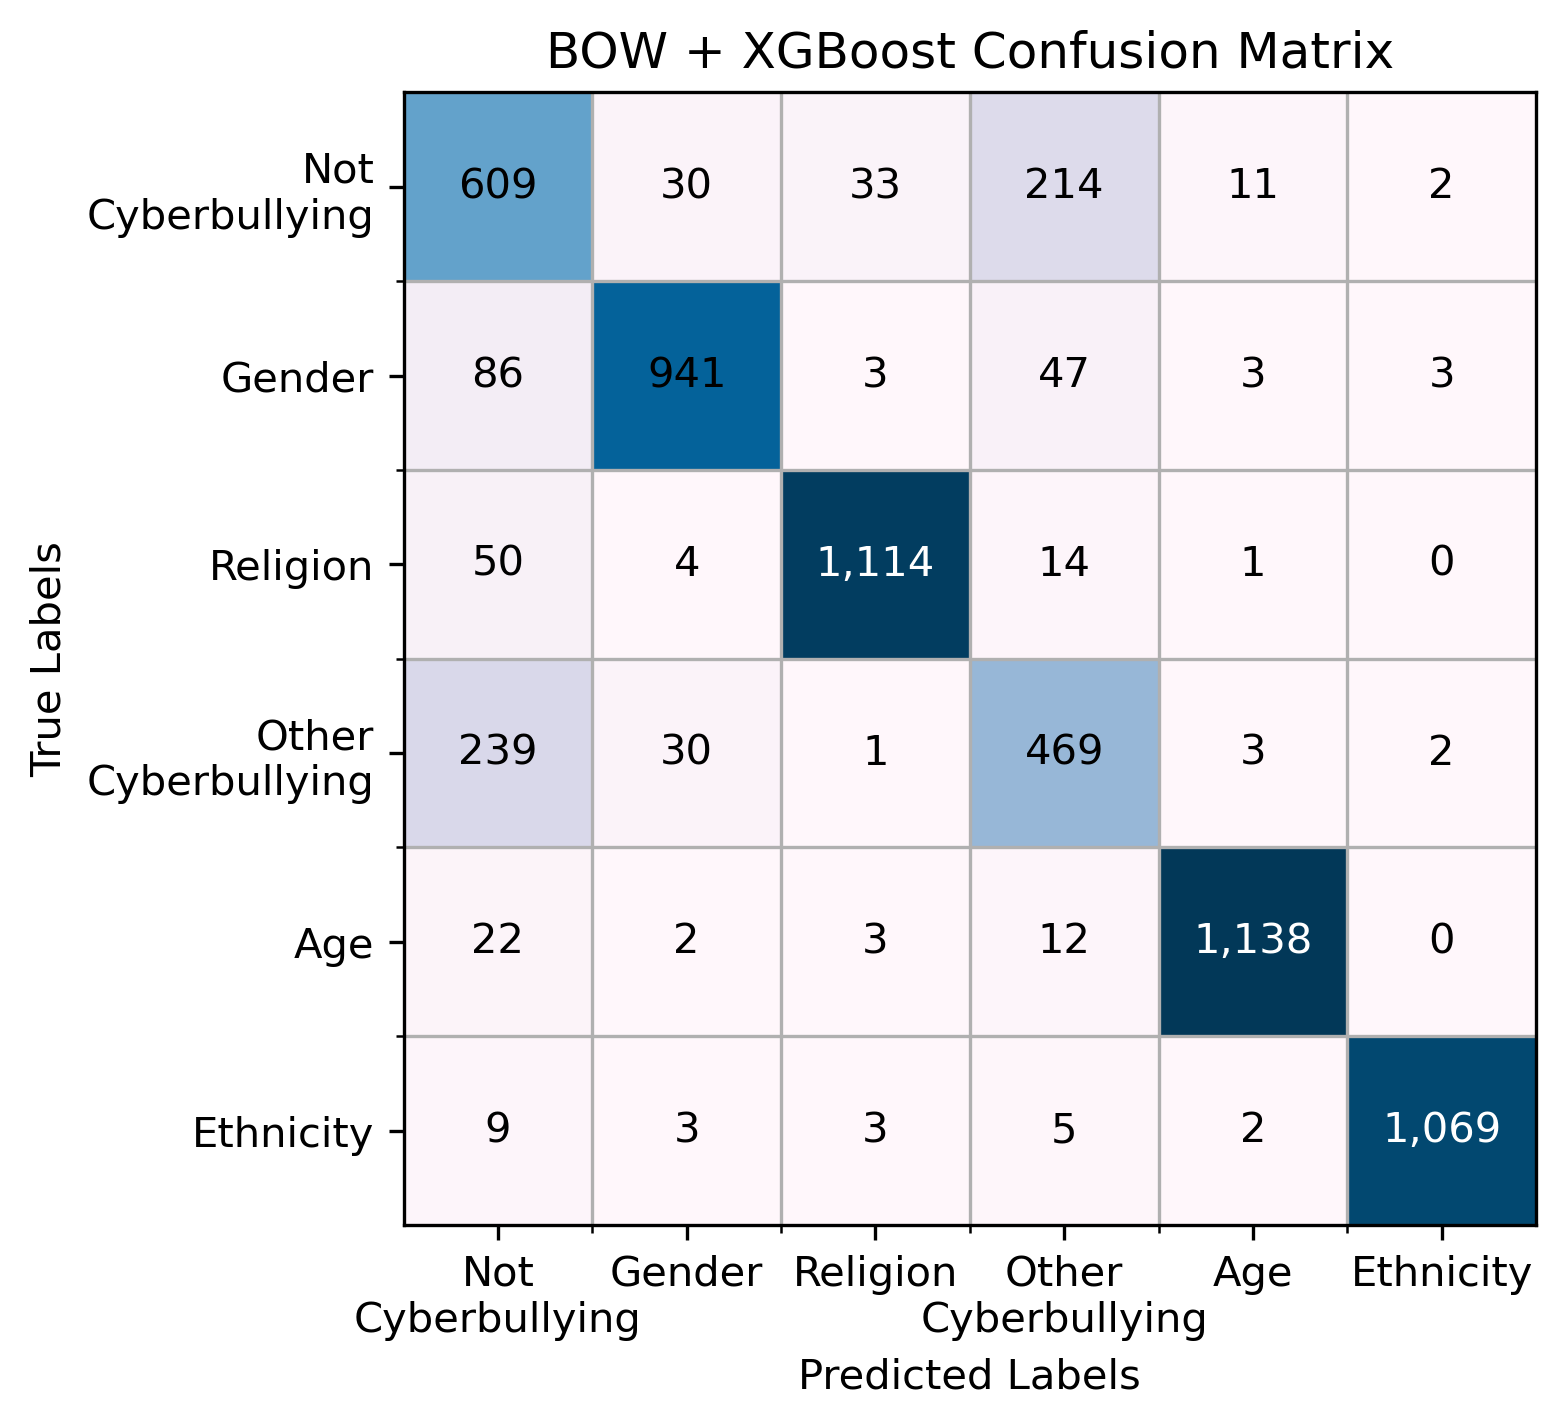

In [13]:
plt.rcParams["figure.figsize"] = [5,5]
plt.rcParams["figure.dpi"] = 300

fig, ax = plt.subplots()
conf_mat = confusion_matrix(y_test, y_pred_xgb_bow)

ax.matshow(conf_mat, cmap = "PuBu")

ylabels = ["Not Cyberbullying", "Gender", "Religion", "Other Cyberbullying", "Age", "Ethnicity"]
xlabels = ["Not\nCyberbullying", "Gender", "Religion", "Other\nCyberbullying", "Age", "Ethnicity"]

ax.set_yticks(np.arange(6), xlabels)
ax.set_xticks(np.arange(6), xlabels)

#set minor ticks for grid seperation
ax.set_xticks(np.arange(0.5, 5.5, 1), minor=True)
ax.set_yticks(np.arange(0.5, 5.5, 1), minor=True)

ax.xaxis.set_ticks_position("bottom")

#add in labels for numbers 
for (i, j), z in np.ndenumerate(conf_mat):
    if z > 1000: 
        ax.text(j, i, '{:,}'.format(z), ha='center', va='center', color = "white")
    else: 
        ax.text(j, i, '{:,}'.format(z), ha='center', va='center')

ax.grid(which="minor")
ax.set_ylabel("True Labels")
ax.set_xlabel("Predicted Labels")
ax.set_title("BOW + XGBoost Confusion Matrix")

plt.savefig("../../plots/xgb_confmat.png", bbox_inches = "tight")

# Probability Averaging Ensemble 

While the three models have similar accuracy they may perform differently class by class. With the probability averaging ensemble the three model probabilties per class are averaged before a classification is chosen. 

In [39]:
#retrain svms to enable probability
svm_bow = SVC(max_iter = 10000, C = 0.13422383454969025, probability = True,
                kernel = "linear").fit(X_train_bow, y_train)

svm_tfidf = SVC(max_iter = 10000, C = 0.9384186373383406, probability = True,
                kernel = "linear").fit(X_train_tfidf, y_train)

In [82]:
#bow ensemble 
avg_probs_bow = np.mean(np.array([
        log_reg_bow.predict_proba(X_test_bow),
        xgb_bow.predict(D_test_bow),
        svm_bow.predict_proba(X_test_bow)]), axis = 0)

y_pred_ens_bow = np.argmax(avg_probs_bow, axis = 1)

#tfidf ensemble
avg_probs_tfidf = np.mean(np.array([
        log_reg_tfidf.predict_proba(X_test_tfidf),
        xgb_tfidf.predict(D_test_tfidf),
        svm_tfidf.predict_proba(X_test_tfidf)]), axis = 0)

y_pred_ens_tfidf = np.argmax(avg_probs_tfidf, axis = 1)

In [83]:
print("BOW Embedding Classification Report")
print(f"Model Accuracy: {accuracy(y_test, y_pred_ens_bow)}")
print(classification_report(y_test, y_pred_ens_bow), "\n")


print("TFIDF Embedding Classification Report")
print(f"Model Accuracy: {accuracy(y_test, y_pred_ens_tfidf)}")
print(classification_report(y_test, y_pred_ens_tfidf), "\n")

BOW Embedding Classification Report
Model Accuracy: 0.8623927472883277
              precision    recall  f1-score   support

           0       0.59      0.66      0.62       899
           1       0.92      0.88      0.90      1083
           2       0.95      0.95      0.95      1183
           3       0.63      0.61      0.62       744
           4       0.98      0.97      0.97      1177
           5       0.99      0.98      0.98      1091

    accuracy                           0.86      6177
   macro avg       0.84      0.84      0.84      6177
weighted avg       0.87      0.86      0.86      6177
 

TFIDF Embedding Classification Report
Model Accuracy: 0.861583292860612
              precision    recall  f1-score   support

           0       0.61      0.62      0.61       899
           1       0.91      0.88      0.89      1083
           2       0.95      0.96      0.95      1183
           3       0.63      0.62      0.62       744
           4       0.96      0.97      0.

In [93]:
models = ["BOW+LR", "BOW+SVM", "BOW+XGB", 
          "TF-IDF+LR", "TF-IDF+SVM", "TF-IDF+XGB"]
predictions = [y_pred_lr_bow, y_pred_svm_bow, y_pred_xgb_bow, 
               y_pred_lr_tfidf, y_pred_svm_tfidf, y_pred_xgb_tfidf]

for model, y_hat in zip(models, predictions): 
    print(model)
    f1_macro = f1(y_test, y_hat, average="macro")
    print(f"f1:\t{f1_macro:0.4f}", f"accuracy:\t{accuracy(y_test, y_hat):0.4f}\n")


BOW+LR
f1:	0.8313 accuracy:	0.8527

BOW+SVM
f1:	0.8345 accuracy:	0.8540

BOW+XGB
f1:	0.8454 accuracy:	0.8645

TF-IDF+LR
f1:	0.8242 accuracy:	0.8473

TF-IDF+SVM
f1:	0.8361 accuracy:	0.8575

TF-IDF+XGB
f1:	0.8360 accuracy:	0.8559

